In [56]:
library(tidyverse)
library(magrittr)
library(caret)
library(zeallot)
source("R/hte_caret.R")

In [57]:
model_specs = list(
gbm = list(
    tune_grid = expand.grid(
        n.trees = seq(1,501,20), 
        interaction.depth=3, 
        shrinkage = 0.1, 
        n.minobsinnode=3),
    extra_args = list(
        verbose=F, 
        bag.fraction=1)),
glmnet = list(
    tune_grid = expand.grid(
       alpha=c(0,0.5,1),
       lambda=exp(seq(-5,2,0.2))),
    extra_args = list())
)

In [58]:
make_matrix = function(x) stats::model.matrix(~.-1, x)

In [5]:
n = 2000
x = data.frame("covariate_1" = rnorm(n), "covariate_2"= rnorm(n)) %>% make_matrix
logit_p = (x %*% c(1,1))
p = exp(logit_p)/(1+exp(logit_p))
# p = 0.5
w = rbinom(n,1,p)==1
tau = (x %*% c(1,1))^2
y = (x %*% c(1,-3) + tau/2*(2*w-1))[,1]
ybin = factor(ifelse(y>0, "treated", "control"))
weights = rnorm(n,1,0.1)
i_tr = 1:floor(n*0.5)

muhat_val = cross_validated_cross_estimation(x[-i_tr,], y[-i_tr], model_specs) 
phat_val = cross_validated_cross_estimation(x[-i_tr,], w[-i_tr], model_specs)
a = y[-i_tr] - muhat_val
b = w[-i_tr] - phat_val

Warning message:
: package ‘bindrcpp’ was built under R version 3.2.5

----

In [41]:
r_model = R_learner_cv(
    x[i_tr,], w[i_tr], y[i_tr], 
    model_specs, model_specs, model_specs) 
tauhat_r_te = predict(r_model, newdata=x[-i_tr,])
tauhat_r_tr = predict(r_model, newdata=x[i_tr,])

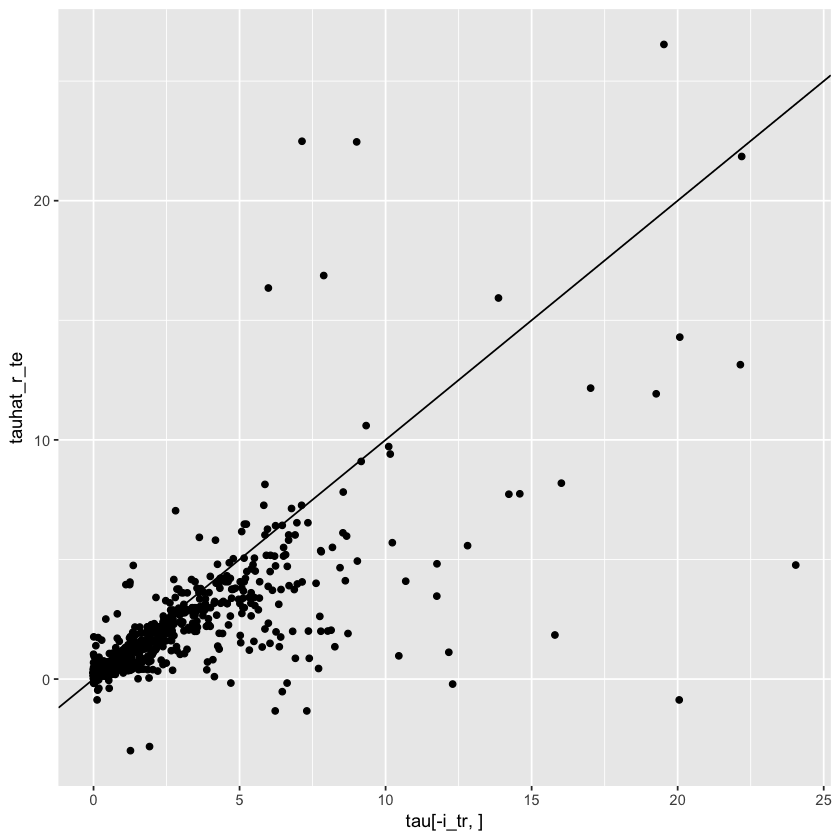

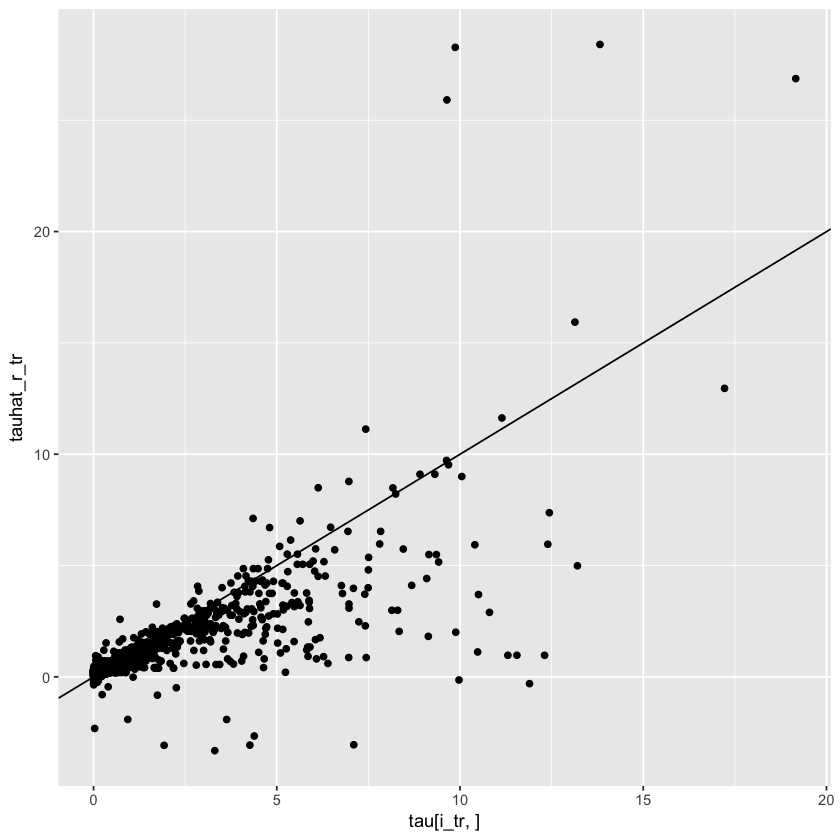

In [42]:
qplot(tau[-i_tr,], tauhat_r_te) + geom_abline(slope=1)
qplot(tau[i_tr,], tauhat_r_tr) + geom_abline(slope=1)

In [43]:
pp = R_learners_pred_test(i_tr, x, w, y, model_specs, model_specs, model_specs)

In [44]:
r_model_cv_name = r_model$bestTune %>%
    unite(model, names(r_model$bestTune), sep="~") %>%
    mutate(model = str_c(r_model$method, model, sep="@")) %>%
    pull(model) %>% first

In [45]:
tauhat_r_te_2 = pp %>% filter(model==r_model_cv_name) %>% arrange(index) %>% pull(yhat)

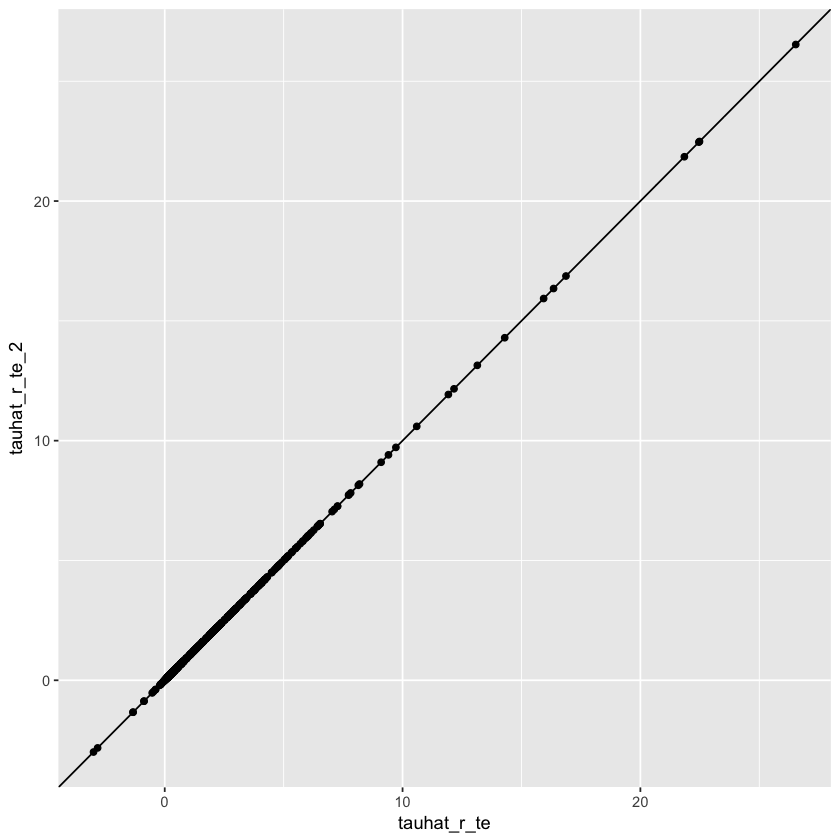

In [46]:
qplot(tauhat_r_te, tauhat_r_te_2) + geom_abline(slope=1)

In [47]:
tmses = pp %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((yhat - tau[-i_tr])^2))

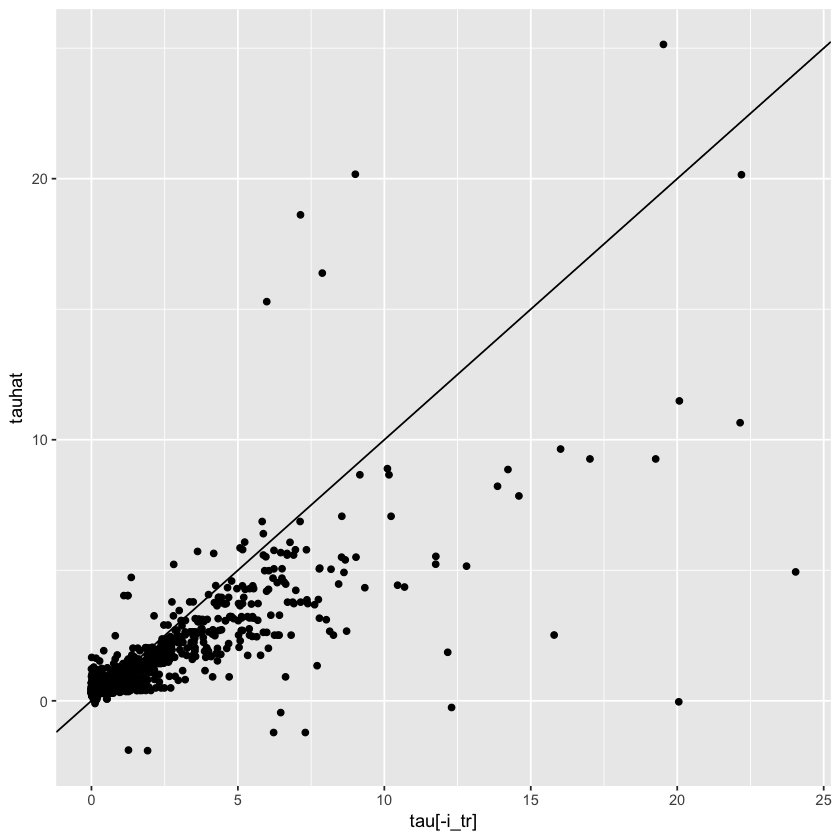

In [48]:
best_model = tmses %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = pp %>% filter(model==best_model) %>% pull(yhat)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [49]:
best_model

[1] "gbm@101~3~0.1~3"

In [50]:
tmses_hat = pp %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((a-b*yhat)^2))

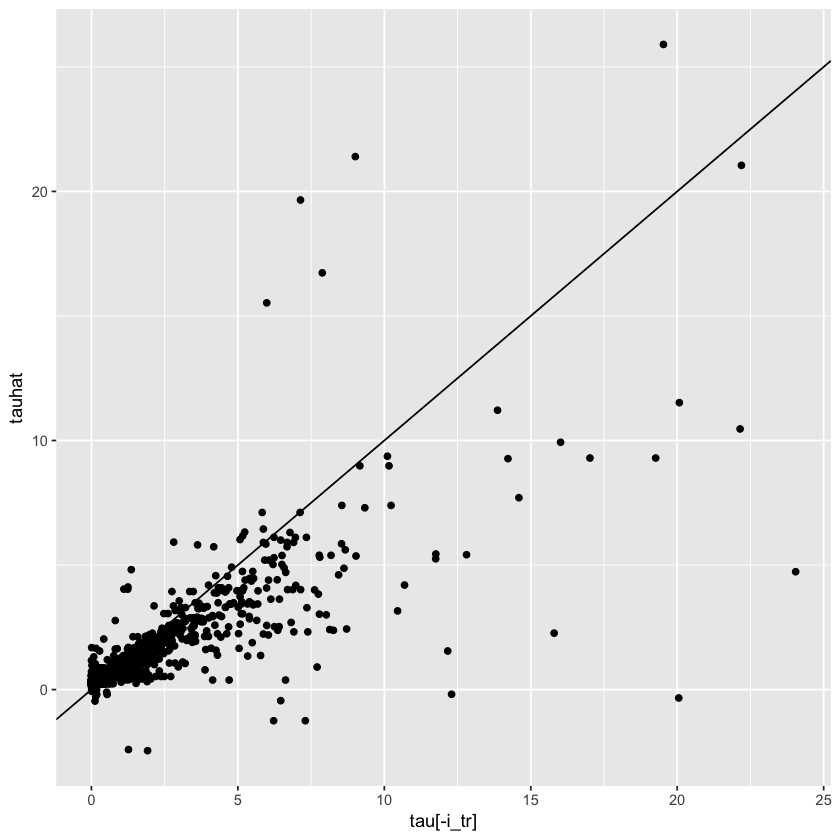

In [51]:
best_model_hat = tmses_hat %>% filter(tmse == min(tmse)) %>% pull(model) %>% first()
tauhat = pp %>% filter(model==best_model_hat) %>% pull(yhat)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [52]:
best_model_hat

[1] "gbm@141~3~0.1~3"

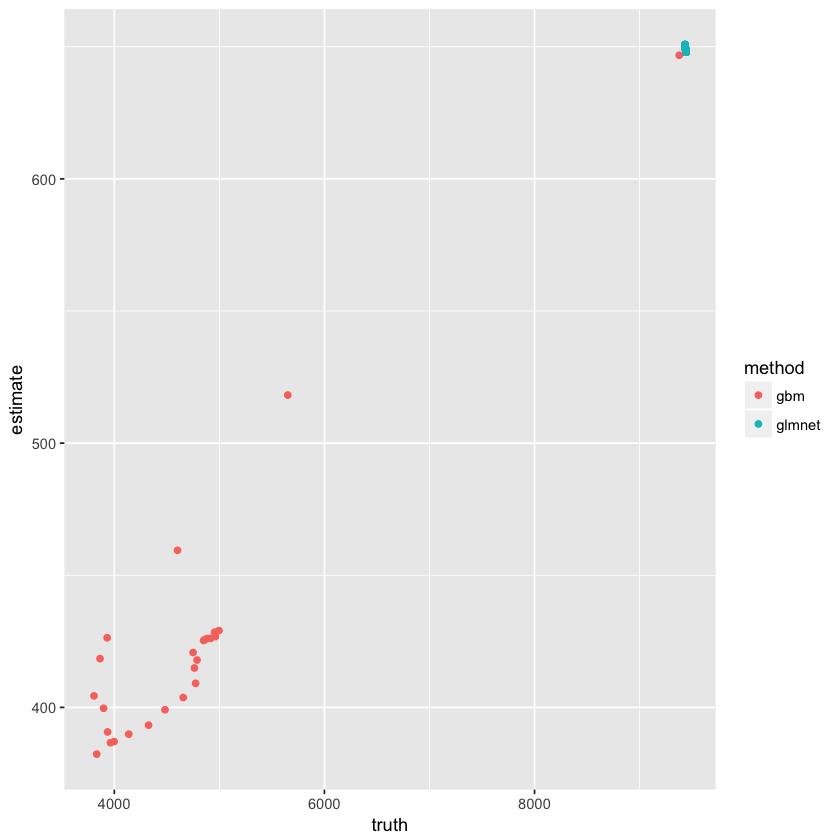

In [53]:
inner_join(tmses, tmses_hat, by="model") %>% 
    rename(truth=tmse.x, estimate=tmse.y) %>%
    separate(model, c("method", "params"), sep="@") %$%
qplot(truth, estimate, color=method) 

----

----

In [59]:
tau_hat_S = T_learners_pred_test(i_tr, x, w, y, model_specs)

In [47]:
tmses = tau_hat_S %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((est_effect - tau[-i_tr])^2))

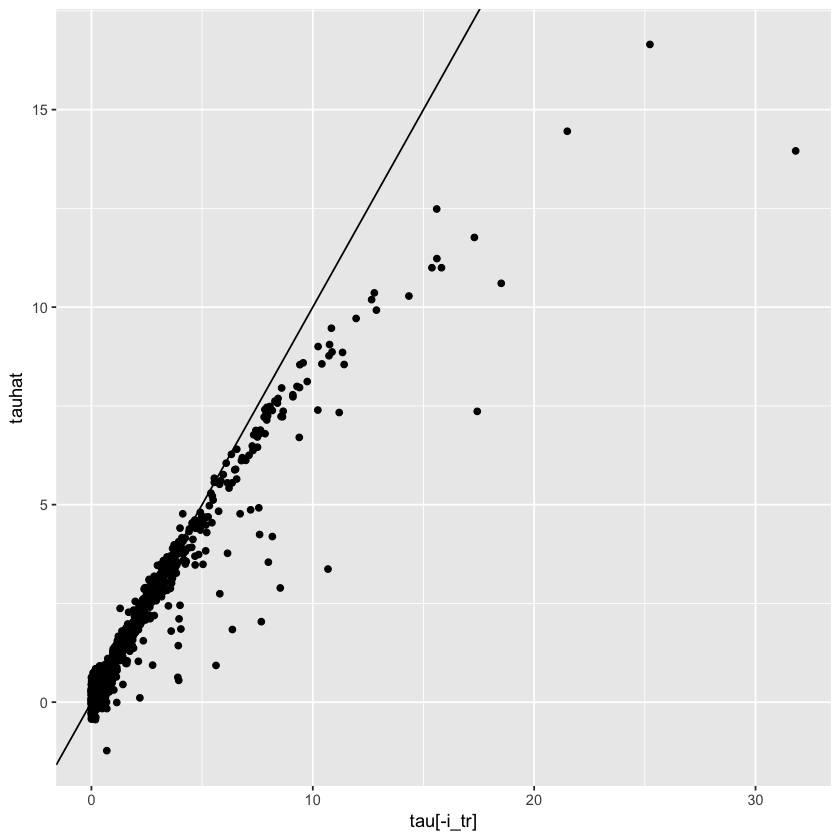

In [48]:
best_model = tmses %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = tau_hat_S %>% filter(model==best_model) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [49]:
tmses_hat = tau_hat_S %>% 
    group_by(model) %>%
    arrange(index) %>%
    summarize(tmse = sum((a-b*est_effect)^2))

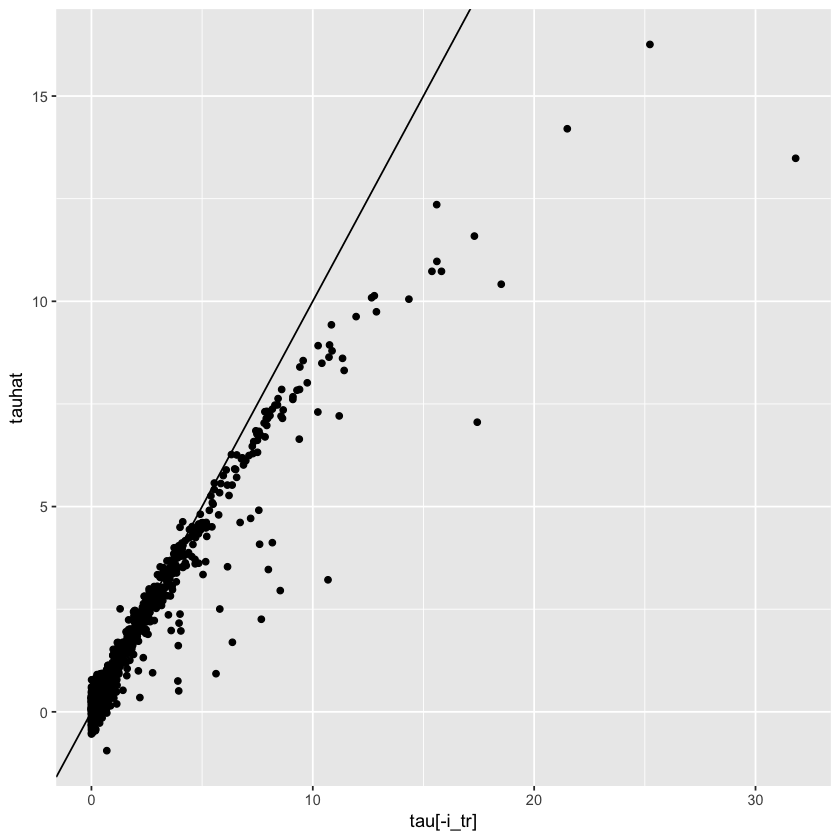

In [50]:
best_model_hat = tmses_hat %>% filter(tmse == min(tmse)) %>% pull(model) %>% last()
tauhat = tau_hat_S %>% filter(model==best_model_hat) %>% pull(est_effect)
qplot(tau[-i_tr], tauhat) + geom_abline(slope=1)

In [51]:
best_model_hat

[1] "gbm@221~3~0.1~3"

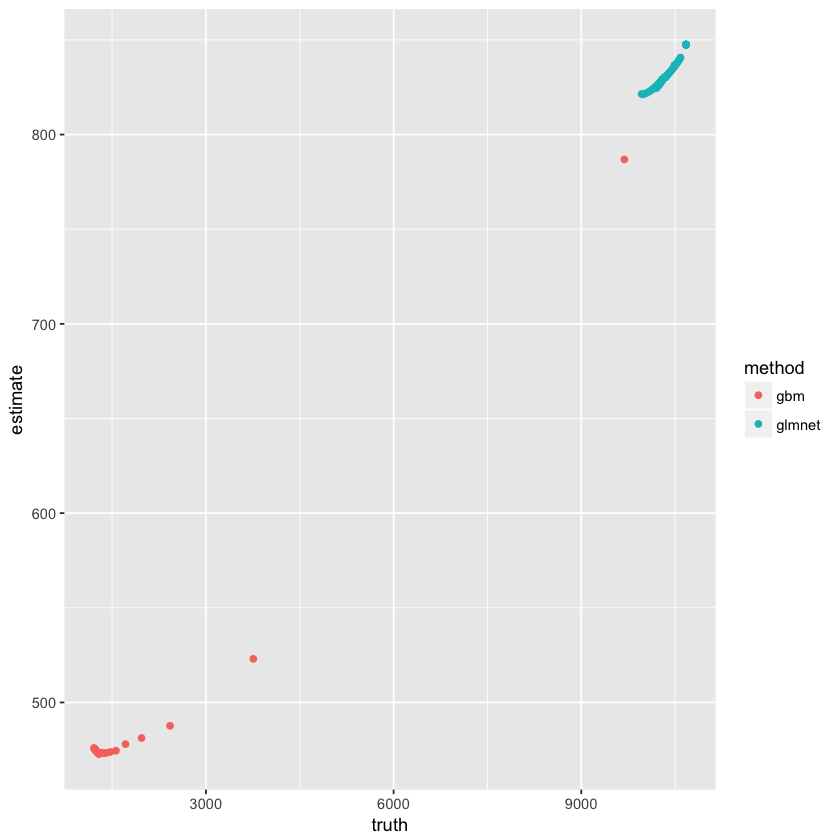

In [52]:
inner_join(tmses, tmses_hat, by="model") %>% 
    rename(truth=tmse.x, estimate=tmse.y) %>%
    separate(model, c("method", "params"), sep="@") %$%
qplot(truth, estimate, color=method) 